El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm

from src.datasets import daocensus_text, to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent
from src.utils import notebooks as nbutils

sns.set_theme()

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


/tmp/ipykernel_3899334/804985562.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Dataset splits config
N_SPLITS: int = 10

# Always 0, just skip the first rows in the CSV to compare with others
SKIP_SPLIT: int = 0

# the second way of making splits
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_SPLITS: int = 10 # Only used to generate baseline graph

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

ORG_NAME: str = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

CUTOFF_DATE_STR = ... # Not used

In [3]:
# Parameters
ORG_NAME = "PancakeSwap"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "3d"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-21"
CUTOFF_DATE_STR = "2023-07-01"


# Load data

In [4]:
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
print(dfv.info())
print(dfp.info())

Warning, removing 532830 votes without proposal


<class 'pandas.core.frame.DataFrame'>
Int64Index: 532830 entries, 0 to 532829
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       532830 non-null  object        
 1   name           532830 non-null  object        
 2   id             532830 non-null  object        
 3   proposal       532830 non-null  category      
 4   deployment     532830 non-null  object        
 5   platform_vote  532830 non-null  object        
 6   voter          532830 non-null  category      
 7   date           532830 non-null  datetime64[ns]
 8   choice         532830 non-null  object        
 9   weight         532830 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 40.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2691 entries, 0 to 2690
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------

In [5]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0x71aa938631f32011303150bd7d1c7f4b5d2f3694,32d8d279-eb34-5718-9081-4deb1b662a37,2021-12-07 17:59:03,1
1,0xfee6b5d6fd92e64248e5af14023a19bf0cbaa04a,32d8d279-eb34-5718-9081-4deb1b662a37,2021-12-07 17:56:45,1
2,0x077f6c80a1c43a63db6892b85bed5205c0afbc4f,32d8d279-eb34-5718-9081-4deb1b662a37,2021-12-07 17:27:49,1
3,0x5473b5210b996ac3809996e9e9dd4d716d3df08c,32d8d279-eb34-5718-9081-4deb1b662a37,2021-12-07 17:22:02,1
4,0xe99ce54c794408f6c162f9dc4e7fedc4ab3a04f2,32d8d279-eb34-5718-9081-4deb1b662a37,2021-12-07 13:59:15,1


# Exploring data

## How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                           2691
mean      25 days 15:21:30.978446674
std      152 days 18:02:07.925171586
min                  0 days 00:00:57
25%                  3 days 00:00:00
50%                  6 days 11:00:00
75%                 23 days 00:15:00
max               7360 days 13:15:00
dtype: object

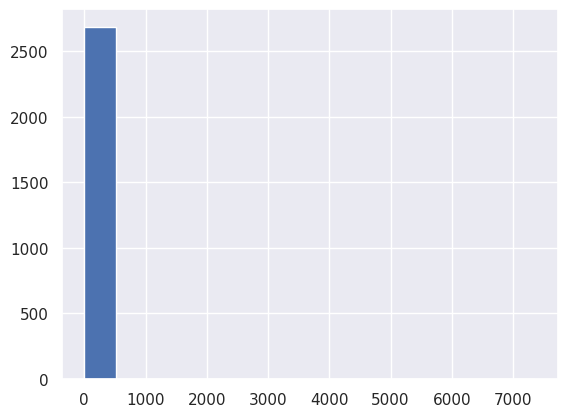

In [6]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

In [7]:
delta.value_counts()

3 days 00:00:00      464
1 days 00:00:00      222
7 days 00:00:00      131
2 days 00:00:00       61
31 days 00:00:00      50
                    ... 
129 days 14:15:00      1
2 days 10:00:00        1
259 days 17:00:00      1
61 days 01:15:00       1
11 days 23:45:00       1
Length: 1002, dtype: int64

### Just for MetaCartel, avg proposal length in time

<Axes: xlabel='date'>

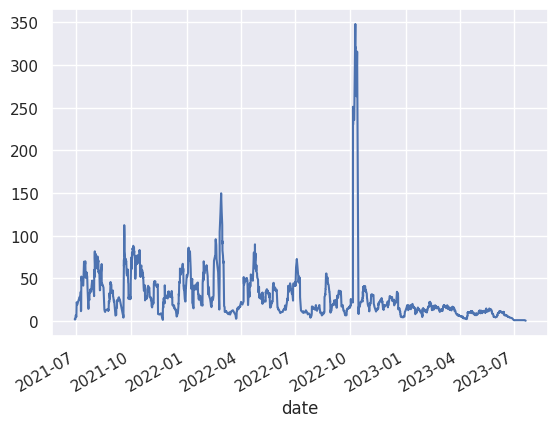

In [8]:
# TODO
_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling('7D').mean().plot()

## What day or the week are proposals created

Thursday     458
Friday       439
Wednesday    421
Monday       373
Tuesday      373
Saturday     329
Sunday       298
Name: start, dtype: int64

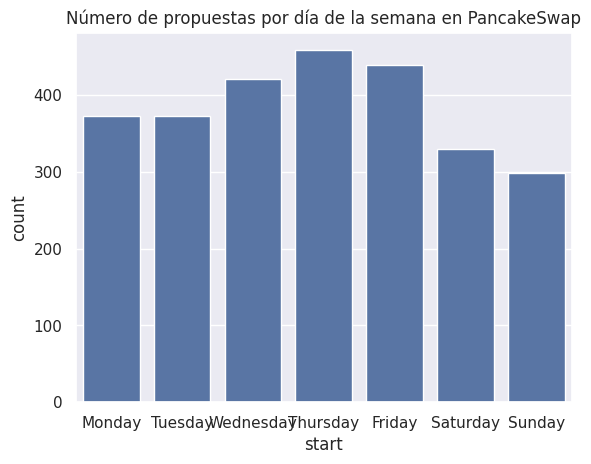

In [9]:
import seaborn as sns

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
dfp['start'].dt.day_name().value_counts()

Text(0, 0.5, '')

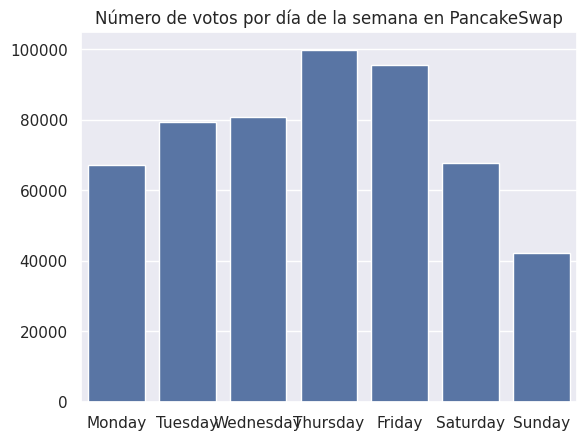

In [10]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de votos por día de la semana en {ORG_NAME}')
dfv['date'].dt.day_name().value_counts()
plt.xlabel('')
plt.ylabel('')

## Ahora en porcentaje acumulado

<Axes: xlabel='rel_day', ylabel='proposals'>

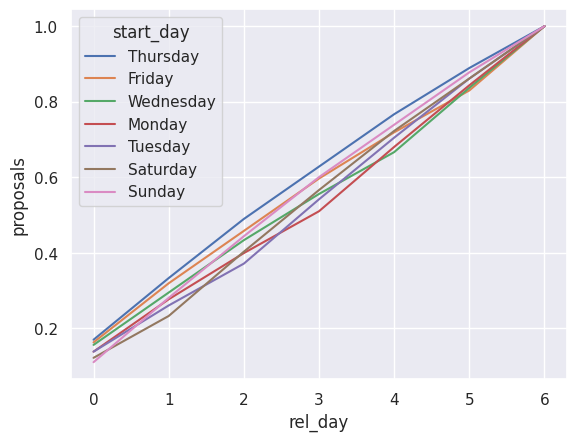

In [11]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfp['start'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='proposals') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='proposals', hue='start_day')

### Same with votes

<Axes: xlabel='rel_day', ylabel='votes'>

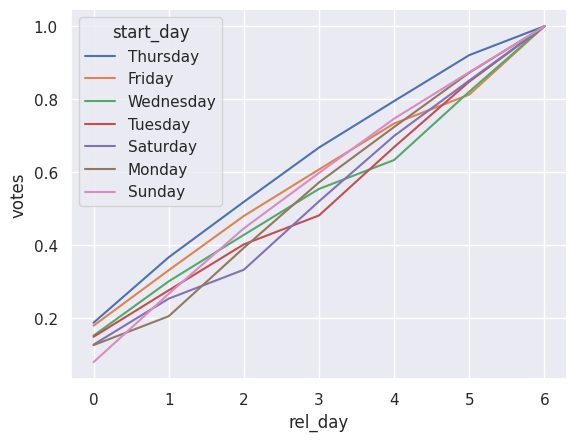

In [12]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfv['date'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='votes') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='votes', hue='start_day')

## How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

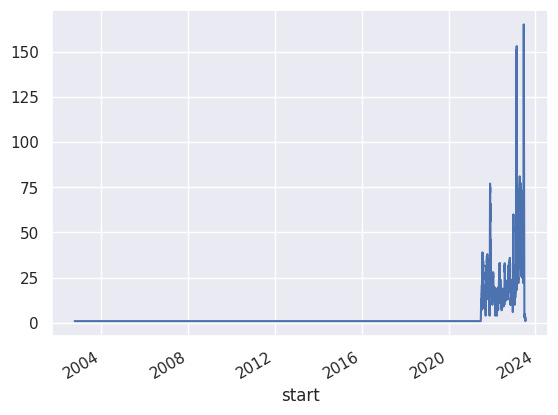

In [13]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## VPP in test per recommendator

In [14]:
freqs = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-SAT']
freq = freqs[0]

results = []
for freq in tqdm(freqs, leave=False):
    for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), freq, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'):
        dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
        
        results.append({
            'f': freq,
            't': t,
            # 'proposals in train': dftrain['itemID'].nunique(),
            # 'votes in train': len(dftrain),
            'votes in open proposals (train)': len(dftrain_filter),
            'users in open proposals (train)': dftrain_filter['userID'].nunique(),
            'open proposals': len(openproposals),
            'votes in test': len(dftest),
            'users in test': dftest['userID'].nunique(),
        })

res = pd.DataFrame(results)
res['vpp test'] = res['votes in test'] / res['open proposals']
res['vpu test'] = res['votes in test'] / res['users in test']
res.groupby('f').describe(percentiles=[]).T[freqs]

  0%|          | 0/6 [00:00<?, ?it/s]

f                                             W-SUN         W-MON  \
votes in open proposals (train) count    106.000000    106.000000   
                                mean   14428.500000  14372.896226   
                                std    10583.521061  10601.043100   
                                min      132.000000    132.000000   
                                50%    14530.000000  14604.500000   
                                max    42712.000000  41643.000000   
users in open proposals (train) count    106.000000    106.000000   
                                mean    6658.896226   6580.037736   
                                std     5004.956633   5024.396265   
                                min      118.000000    118.000000   
                                50%     7360.500000   7392.000000   
                                max    26246.000000  25843.000000   
open proposals                  count    106.000000    106.000000   
                                mean      82.462264     82.811321   
                                std       27.578174     28.149639   
                                min        6.000000      6.000000   
                                50%       88.000000     86.500000   
                                max      142.000000    147.000000   
votes in test                   count    106.000000    106.000000   
                                mean    1242.320755   1219.877358   
                                std     1155.654921   1106.234356   
                                min      134.000000    131.000000   
                                50%     1047.500000   1032.000000   
                                max     9110.000000   8509.000000   
users in test                   count    106.000000    106.000000   
                                mean     384.679245    363.952830   
                                std      165.422492    152.588047   
                                min       61.000000     59.000000   
                                50%      354.500000    344.500000   
                                max      859.000000    779.000000   
vpp test                        count    106.000000    106.000000   
                                mean      15.465252     14.963636   
                                std       11.497008     10.384613   
                                min        4.636364      4.500000   
                                50%       12.536215     12.112803   
                                max       65.071429     59.922535   
vpu test                        count    106.000000    106.000000   
                                mean       2.980043      3.050352   
                                std        1.386843      1.388943   
                                min        1.310078      1.310078   
                                50%        2.722780      2.733345   
                                max       12.462380     11.967651   

f                                             W-TUE         W-WED  \
votes in open proposals (train) count    107.000000    107.000000   
                                mean   14412.514019  14453.504673   
                                std    10720.653570  10839.534940   
                                min       21.000000    239.000000   
                                50%    14590.000000  14718.000000   
                                max    41643.000000  41643.000000   
users in open proposals (train) count    107.000000    107.000000   
                                mean    6644.121495   6716.467290   
                                std     5030.051522   5110.029419   
                                min       19.000000    210.000000   
                                50%     7234.000000   7476.000000   
                                max    25843.000000  25843.000000   
open proposals                  count    107.000000    107.000000   
                                mean      82.682243     82.467290 

In [15]:
res.groupby('f').sum().T[freqs]

/tmp/ipykernel_3899334/4276310820.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby('f').sum().T[freqs]


f,W-SUN,W-MON,W-TUE,W-WED,W-THU,W-SAT
votes in open proposals (train),1.529421e+06,1.523527e+06,1.542139e+06,1.546525e+06,1.558227e+06,1.549224e+06
users in open proposals (train),7.058430e+05,6.974840e+05,7.109210e+05,7.186620e+05,7.320050e+05,7.183170e+05
open proposals,8.741000e+03,8.778000e+03,8.847000e+03,8.824000e+03,8.870000e+03,8.847000e+03
votes in test,1.316860e+05,1.293070e+05,1.382010e+05,1.386410e+05,1.456030e+05,1.437750e+05
users in test,4.077600e+04,3.857900e+04,4.577800e+04,4.318000e+04,4.685300e+04,4.701800e+04
vpp test,1.639317e+03,1.586145e+03,1.698139e+03,1.701428e+03,1.775043e+03,1.797527e+03
vpu test,3.158846e+02,3.233373e+02,2.977307e+02,3.111724e+02,3.127667e+02,3.106860e+02


# Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [16]:
from src.baseline import getBaselineRecommendations

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

"\ndef getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):\n    bestVotes = train['itemID'].value_counts()\n    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])\n\n    if remove_train:\n        df = filter_by(df, train, ['userID', 'itemID'])\n        \n    df = df.groupby('userID').head(k).reset_index(drop=True)\n\n    df['prediction'] = True\n    return df\n"

# Evaluating the baseline recommendator with `timeIntervalSplit`

In [17]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [18]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [19]:
from collections import defaultdict

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
# perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2021-09-04 20:04:51)  =====
Currently open proposals: 41
Train votes in open proposals: 1758
Test votes in open proposals:  310



===== Training on fold 1 (t: 2021-11-12 04:10:22)  =====
Currently open proposals: 107
Train votes in open proposals: 9573
Test votes in open proposals:  1019



===== Training on fold 2 (t: 2022-01-19 12:06:19)  =====
Currently open proposals: 97
Train votes in open proposals: 41288
Test votes in open proposals:  944



===== Training on fold 3 (t: 2022-03-28 19:21:38)  =====
Currently open proposals: 79
Train votes in open proposals: 40143
Test votes in open proposals:  477



===== Training on fold 4 (t: 2022-06-05 03:28:16)  =====
Currently open proposals: 89
Train votes in open proposals: 17115
Test votes in open proposals:  1016



===== Training on fold 5 (t: 2022-08-12 11:35:53)  =====
Currently open proposals: 81
Train votes in open proposals: 15306
Test votes in open proposals:  916



===== Training on fold 6 (t: 2022-10-19 19:38:51)  =====
Currently open proposals: 98
Train votes in open proposals: 15256
Test votes in open proposals:  730



===== Training on fold 7 (t: 2022-12-27 03:46:44)  =====
Currently open proposals: 102
Train votes in open proposals: 20345
Test votes in open proposals:  1608



===== Training on fold 8 (t: 2023-03-05 11:57:33)  =====
Currently open proposals: 113
Train votes in open proposals: 9422
Test votes in open proposals:  732



===== Training on fold 9 (t: 2023-05-12 19:49:13)  =====
Currently open proposals: 79
Train votes in open proposals: 4973
Test votes in open proposals:  615


In [20]:
# from src import paths

# Won't even save it because its not used
# pd.DataFrame(metrics).to_csv(paths.baseline_mp(ORG_NAME, N_SPLITS), index=False)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.037925,0.083911,0.063474,0.097569,0.034486,0.103636,0.072765,0.153185,0.036328,0.125112,0.080899,0.220483,0.395442,0.231768
std,0.046160,0.129453,0.116521,0.152820,0.033423,0.149723,0.126608,0.207456,0.028752,0.160376,0.131788,0.242336,0.052780,0.039155
min,0.007560,0.007958,0.001685,0.003573,0.006186,0.013361,0.003020,0.006498,0.005498,0.017389,0.006525,0.032731,0.335570,0.188942
25%,0.009504,0.014899,0.006676,0.017323,0.015326,0.020159,0.009788,0.035201,0.021090,0.034057,0.012036,0.060732,0.369889,0.207790
50%,0.014703,0.016748,0.008468,0.023493,0.023356,0.043458,0.017617,0.073281,0.026106,0.067617,0.026963,0.136329,0.388347,0.225806
75%,0.039960,0.060678,0.030203,0.071210,0.032663,0.063986,0.033802,0.096506,0.042090,0.077451,0.039170,0.193440,0.403373,0.246140
max,0.131544,0.368012,0.346946,0.391858,0.101339,0.448018,0.381246,0.594168,0.090030,0.482962,0.398082,0.684523,0.518415,0.324709


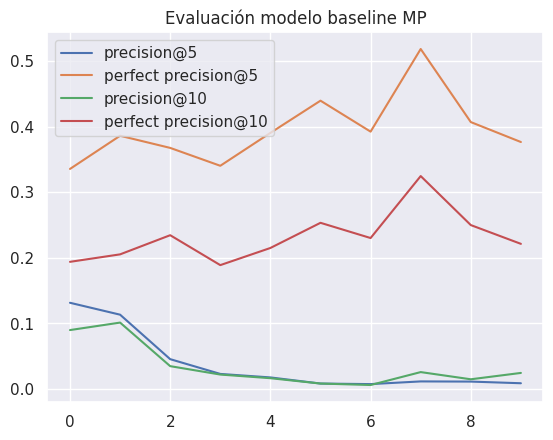

In [21]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,10.000000,10.0,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.0,10.000000,10.000000
mean,0.395442,1.0,0.954223,0.954223,0.231768,1.0,0.983503,0.983503,0.165099,1.0,0.991873,0.991873
std,0.052780,0.0,0.021515,0.021515,0.039155,0.0,0.010511,0.010511,0.030077,0.0,0.006364,0.006364
min,0.335570,1.0,0.917098,0.917098,0.188942,1.0,0.961039,0.961039,0.131991,1.0,0.977726,0.977726
25%,0.369889,1.0,0.940061,0.940061,0.207790,1.0,0.979730,0.979730,0.141989,1.0,0.989198,0.989198
50%,0.388347,1.0,0.955998,0.955998,0.225806,1.0,0.985959,0.985959,0.160436,1.0,0.993434,0.993434
75%,0.403373,1.0,0.970218,0.970218,0.246140,1.0,0.987649,0.987649,0.179387,1.0,0.996572,0.996572
max,0.518415,1.0,0.983731,0.983731,0.324709,1.0,0.996162,0.996162,0.231391,1.0,0.998110,0.998110


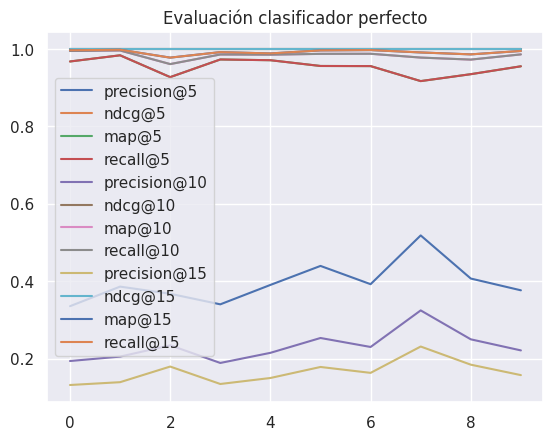

In [22]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

# Evaluation the baseline recommendator with `timeFreqSplit`

In [23]:
from tqdm.autonotebook import tqdm

In [24]:
from functools import partial
import sys

folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(tqdm(folds)):
    t = train.timestamp.max()

    assert not train.empty, f"Train should not be empty on fold {i}"
    # assert not test.empty, f"Test should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False

        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    # print()

  0%|          | 0/249 [00:00<?, ?it/s]

In [25]:
print(df['timestamp'].min(), df['timestamp'].max())
_folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE, inclusive='right', return_open=True))
_, _, t, _ = _folds[0]
print("t0:", t)
_, _, t, _ = _folds[1]
print("t1:", t)
_, _, t, _ = _folds[-2]
print("t-2:", t)
_, _, t, _ = _folds[-1]
print("t-1:", t)

2021-06-28 12:14:46 2023-07-20 03:54:45


t0: 2021-07-01 00:00:00
t1: 2021-07-04 00:00:00
t-2: 2023-07-12 00:00:00
t-1: 2023-07-15 00:00:00


In [26]:
{ k:len(v) for k,v in metrics.items() }

{'t': 249,
 'precision@5': 249,
 'ndcg@5': 249,
 'map@5': 249,
 'recall@5': 249,
 'precision@10': 249,
 'ndcg@10': 249,
 'map@10': 249,
 'recall@10': 249,
 'precision@15': 249,
 'ndcg@15': 249,
 'map@15': 249,
 'recall@15': 249}

In [27]:
display(dfp['date'].min())
display(df['timestamp'].min())
display(df.sort_values('timestamp').head())
display(dfp.sort_values('date').head())

Timestamp('2021-06-28 12:14:26')

Timestamp('2021-06-28 12:14:46')

,userID,itemID,timestamp,rating
221486,0x8b017905dc96b38f817473dc885f84d4c76bc113,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 12:14:46,1
221485,0x9e882c739493886ab2865803432d3140b6473bfc,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 12:41:42,1
221484,0x1e5c8c04e56f88c09ad775e43a164de264d6dad7,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 12:42:56,1
221483,0x977e0c1005dff8749f8cac22f4df0bd5f013d1a7,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 12:54:31,1
221482,0x1ce49ed469b2c0edf50b574cea9a196bbe23655b,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 16:02:34,1


,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,title,description,start,end,votes_count
2504,snapshot,PancakeSwap,cakevote.eth,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,QmdT8f7BP2YhaCEFmxURgqN4E4iGAviBUG1Q7rocBwGfG1,0x8b017905dc96b38f817473dc885f84d4c76bc113,2021-06-28 12:14:26,Best Feature of PancakeSwap V2,Vote on your favorite feature (or one you use ...,2021-06-27 15:00:00,2021-06-29 22:30:00,38
1815,snapshot,PancakeSwap,cakevote.eth,7ff063f6-838c-591f-a6ff-ee8ed894b25a,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,QmfDqrSAYQY4BieB7Xh2jdc6mGwyfWoP9Lxw5ecdP1L7si,0x54f292760e248cfe64191c7d85260f9ddaa01f2b,2021-06-28 18:15:36,test or TEST,vote!,2021-06-26 22:00:00,2021-06-29 22:00:00,12
1234,snapshot,PancakeSwap,cakevote.eth,c3b110dc-0131-5c42-98d5-0d7cdf40acca,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,QmWBiott8Z9t4jMiMNv5oP6XZsERcvLhDed8NP4NPDZTtG,0x1ce49ed469b2c0edf50b574cea9a196bbe23655b,2021-06-28 18:25:30,[V2] All Time Favorite CheF,Please vote on your favorite Chef,2021-06-26 22:00:00,2021-06-29 22:00:00,34
2108,snapshot,PancakeSwap,cakevote.eth,43d09929-99cb-5890-9e4d-c7d76a9c64f7,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,Qmbpsio389rXe6xaA38ztPVVHH2kBthhRsL2y13VNdt5va,0x7f054f88aa44a8f7c97c8f7e06534374080ac9b1,2021-06-29 03:23:13,Best Season,Vote for you favorite season,2021-06-28 16:00:00,2021-06-29 15:45:00,26
2085,snapshot,PancakeSwap,cakevote.eth,733ff8b9-ba54-59c8-b020-53233fff9e0e,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,Qmc3GaCuxVzArae2jRbuaNcFUDzgKPNbHdEe8DnSqTYNzN,0x6eaf1b33b8672c5dc40ab8f4ba3a0111723126c7,2021-06-29 14:06:23,CAKE EMISSION REDUCTION,Once every month PancakeSwap holds a CAKE emis...,2021-06-29 13:45:00,2021-07-01 13:45:00,3049


In [28]:
# Save the data
from pathlib import Path
from src.baseline import write_metrics_baseline

# pd.DataFrame(metrics).set_index('t').to_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_baseline(pd.DataFrame(metrics).set_index('t'), ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,0.058063,0.122730,0.091042,0.156164,0.048725,0.144677,0.102626,0.214896,0.045429,0.163578,0.110104,0.274918,0.395045,0.237084,0.981483
std,0.063650,0.164700,0.149666,0.214404,0.042649,0.170808,0.153326,0.238196,0.034591,0.172031,0.153544,0.250257,0.088975,0.079568,0.025369
min,0.004783,0.005981,0.002342,0.006750,0.004371,0.012418,0.005840,0.020009,0.006317,0.020315,0.009815,0.034071,0.226889,0.117900,0.750712
25%,0.014776,0.022372,0.010350,0.019947,0.019091,0.034103,0.015712,0.053182,0.025455,0.048997,0.019695,0.086081,0.347302,0.193309,0.980046
50%,0.029412,0.037460,0.015868,0.036752,0.032923,0.054735,0.024322,0.083888,0.034495,0.082468,0.032744,0.163514,0.382800,0.220625,0.985870
75%,0.081857,0.172995,0.117460,0.256220,0.065258,0.196822,0.133109,0.333425,0.057856,0.228989,0.147615,0.415759,0.416625,0.247429,0.992166
max,0.369231,0.889632,0.878033,1.000000,0.253479,0.902867,0.885231,1.000000,0.211551,0.911253,0.889000,1.000000,0.746521,0.581446,1.000000


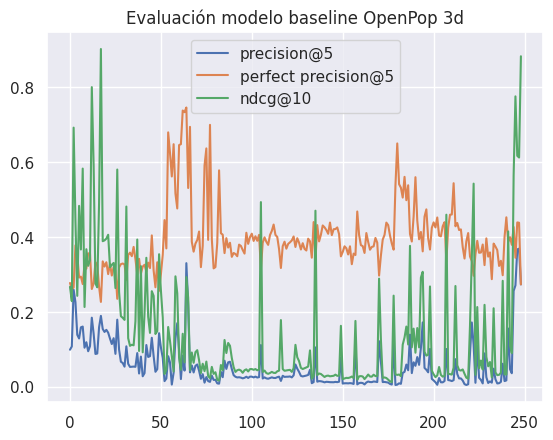

In [29]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf['perfect map@10'] = perfectmetrics['map@10']
mdf[['precision@5', 'perfect precision@5', 'ndcg@10']].plot(title=f'Evaluación modelo baseline OpenPop {SPLITS_FREQ}')
mdf.describe()

In [30]:
mdf[-LAST_SPLITS:].describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.180918,0.373071,0.311015,0.490691,0.114383,0.413647,0.342188,0.587417,0.080465,0.421516,0.344656,0.612605,0.394262,0.206938,0.997138
std,0.143859,0.307293,0.284812,0.396664,0.088798,0.323647,0.293789,0.449649,0.054653,0.314794,0.291168,0.421195,0.053578,0.034135,0.004138
min,0.015238,0.025549,0.013877,0.024958,0.014762,0.032777,0.017181,0.045535,0.018413,0.048997,0.022559,0.095110,0.273684,0.136842,0.988482
25%,0.039007,0.084436,0.057576,0.112160,0.026830,0.095095,0.063399,0.149819,0.029244,0.121356,0.070504,0.218274,0.381321,0.197145,0.995275
50%,0.206051,0.399109,0.324162,0.513332,0.111639,0.490037,0.391764,0.731456,0.075845,0.491779,0.392386,0.736945,0.400000,0.216190,1.000000
75%,0.273022,0.557876,0.409710,0.860727,0.205690,0.616272,0.469215,1.000000,0.137126,0.616272,0.469215,1.000000,0.435617,0.219193,1.000000
max,0.369231,0.883452,0.842105,1.000000,0.219672,0.883452,0.842105,1.000000,0.146448,0.883452,0.842105,1.000000,0.452991,0.266667,1.000000


,t,model,variable,value
0,2021-06-30 23:48:50,openpop,precision@5,0.099099
1,2021-07-02 17:09:24,openpop,precision@5,0.107812
2,2021-07-06 23:57:13,openpop,precision@5,0.259406
3,2021-07-09 23:24:00,openpop,precision@5,0.226277
4,2021-07-12 23:50:23,openpop,precision@5,0.139037
...,...,...,...,...
991,2023-07-02 20:52:40,perfect,recall@5,0.995288
992,2023-07-05 23:57:06,perfect,recall@5,0.999425
993,2023-07-08 23:37:10,perfect,recall@5,1.000000
994,2023-07-11 23:24:07,perfect,recall@5,1.000000


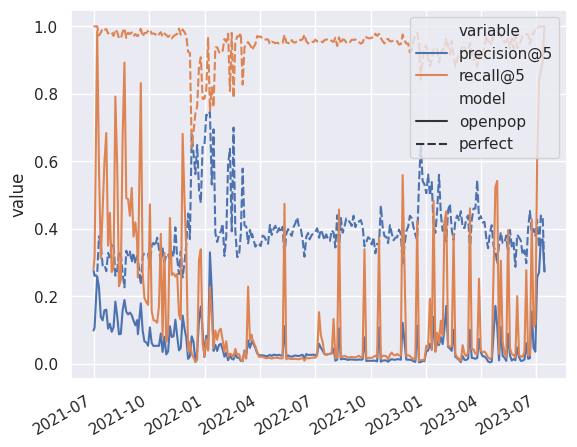

In [31]:
_METRICS = ['precision@5', 'recall@5']

_toplot = pd.concat([
    pd.DataFrame(metrics).assign(model='openpop'),
    pd.DataFrame(perfectmetrics).assign(model='perfect')
])
_toplot = _toplot[['t', 'model'] + _METRICS].melt(id_vars=['t', 'model'])
display(_toplot)

sns.lineplot(_toplot, x='t', y='value', hue='variable', style='model')
plt.xlabel("")
plt.xticks(rotation=30, ha='right');

In [32]:
def _plot_metric(metric):
    _toplot = pd.concat([
        pd.DataFrame(metrics).assign(model='openpop'),
        pd.DataFrame(perfectmetrics).assign(model='perfect')
    ])

    display(_toplot)
    ax = sns.lineplot(_toplot, x='t', y=metric, style='model')
    plt.xlabel("")
    plt.xticks(rotation=30, ha='right');
    return ax

nbutils.download_matplotlib(ax.figure, f'10_all_precision@5_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2021-06-30 23:48:50,0.099099,0.267201,0.234484,0.280781,0.049550,0.267201,0.234484,0.280781,0.033033,0.267201,0.234484,0.280781,openpop
1,2021-07-02 17:09:24,0.107812,0.228989,0.182628,0.317057,0.053906,0.228989,0.182628,0.317057,0.035938,0.228989,0.182628,0.317057,openpop
2,2021-07-06 23:57:13,0.259406,0.692672,0.586304,0.985644,0.129703,0.692672,0.586304,0.985644,0.086469,0.692672,0.586304,0.985644,openpop
3,2021-07-09 23:24:00,0.226277,0.333026,0.201198,0.581823,0.189781,0.443603,0.287037,0.874029,0.142092,0.479051,0.306390,0.992092,openpop
4,2021-07-12 23:50:23,0.139037,0.197425,0.118370,0.312844,0.102674,0.243116,0.147974,0.440285,0.088414,0.275876,0.167152,0.537420,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-07-02 20:52:40,0.427083,1.000000,0.995288,0.995288,0.216667,1.000000,1.000000,1.000000,0.144444,1.000000,1.000000,1.000000,perfect
245,2023-07-05 23:57:06,0.344828,1.000000,0.999425,0.999425,0.172759,1.000000,1.000000,1.000000,0.115172,1.000000,1.000000,1.000000,perfect
246,2023-07-08 23:37:10,0.439344,1.000000,1.000000,1.000000,0.219672,1.000000,1.000000,1.000000,0.146448,1.000000,1.000000,1.000000,perfect
247,2023-07-11 23:24:07,0.438462,1.000000,1.000000,1.000000,0.219231,1.000000,1.000000,1.000000,0.146154,1.000000,1.000000,1.000000,perfect


Cannot show ipywidgets in text

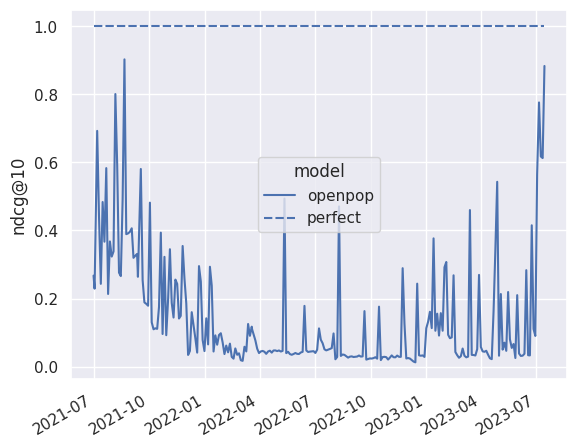

In [33]:
ax = _plot_metric('ndcg@10')
nbutils.download_matplotlib(ax.figure, f'10_all_ndcg@10_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

In [34]:
pmdf

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
0,0.335570,1.0,0.967762,0.967762,0.193960,1.0,0.994916,0.994916,0.131991,1.0,0.996644,0.996644
1,0.386161,1.0,0.983731,0.983731,0.205357,1.0,0.996162,0.996162,0.139286,1.0,0.998110,0.998110
2,0.367647,1.0,0.927349,0.927349,0.234559,1.0,0.961039,0.961039,0.179657,1.0,0.977726,0.977726
3,0.340385,1.0,0.972941,0.972941,0.188942,1.0,0.985813,0.985813,0.134615,1.0,0.991940,0.991940
4,0.390533,1.0,0.971036,0.971036,0.215089,1.0,0.985348,0.985348,0.150099,1.0,0.988569,0.988569
5,0.439640,1.0,0.956153,0.956153,0.253453,1.0,0.987464,0.987464,0.178579,1.0,0.996354,0.996354
6,0.392440,1.0,0.955843,0.955843,0.230241,1.0,0.987711,0.987711,0.163345,1.0,0.997240,0.997240
7,0.518415,1.0,0.917098,0.917098,0.324709,1.0,0.977858,0.977858,0.231391,1.0,0.991084,0.991084
8,0.407018,1.0,0.934966,0.934966,0.250000,1.0,0.972619,0.972619,0.184503,1.0,0.986135,0.986135
9,0.376613,1.0,0.955346,0.955346,0.221371,1.0,0.986105,0.986105,0.157527,1.0,0.994928,0.994928


,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,249.000000,249.0,249.000000,249.000000,249.000000,249.0,249.000000,249.000000,249.000000,249.0,249.000000,249.000000
mean,0.395045,1.0,0.947094,0.947094,0.237084,1.0,0.981483,0.981483,0.169376,1.0,0.989764,0.989764
std,0.088975,0.0,0.050303,0.050303,0.079568,0.0,0.025369,0.025369,0.062056,0.0,0.017042,0.017042
min,0.226889,1.0,0.641104,0.641104,0.117900,1.0,0.750712,0.750712,0.080032,1.0,0.836627,0.836627
25%,0.347302,1.0,0.943857,0.943857,0.193309,1.0,0.980046,0.980046,0.134440,1.0,0.987558,0.987558
50%,0.382800,1.0,0.958369,0.958369,0.220625,1.0,0.985870,0.985870,0.157471,1.0,0.993331,0.993331
75%,0.416625,1.0,0.972819,0.972819,0.247429,1.0,0.992166,0.992166,0.180914,1.0,0.997013,0.997013
max,0.746521,1.0,1.000000,1.000000,0.581446,1.0,1.000000,1.000000,0.520629,1.0,1.000000,1.000000


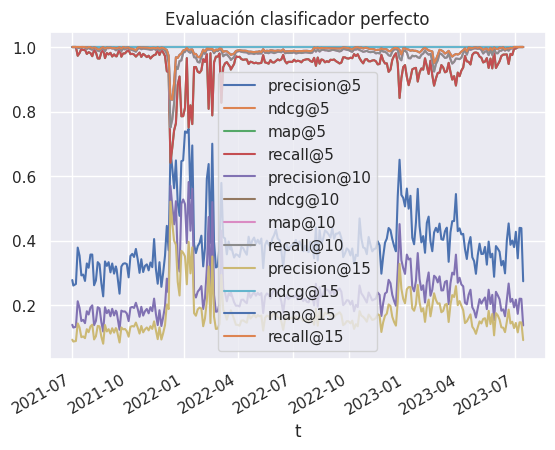

In [35]:
from src.baseline import write_metrics_perfect

pmdf = pd.DataFrame(perfectmetrics).set_index('t')

# pmdf.to_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_perfect(pmdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

## Exploring the folds

In [36]:
print(f"There are {len(folds)} folds")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")

full_len = len(df)
fold_len = []
for tr, ts, t, open_proposals in timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, normalize=SPLITS_NORMALIZE):
    fold_len.append({
        't': t,
        'train': len(tr),
        'test': len(ts),
        'open': len(open_proposals),
        'test users': ts['userID'].nunique(),
        'test vpv': ts['userID'].nunique() / len(ts) if len(ts) else np.NaN,
        'test vpp': ts['userID'].nunique() / ts['itemID'].nunique() if len(ts) else np.NaN,
        # 't_train_min': tr['timestamp'].min(),
        # 't_train_max': tr['timestamp'].max(),
        't_test_min': ts['timestamp'].min(),
        't_test_max': ts['timestamp'].max(),
    })

fold_len = pd.DataFrame(fold_len)
fold_len.describe()

There are 249 folds
From 2021-06-28 12:14:46 to 2023-07-20 03:54:45


,train,test,open,test users,test vpv,test vpp
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,284281.305221,2704.979920,82.823293,1047.722892,0.408348,14.250820
std,160012.654334,2570.636128,27.779389,1124.428353,0.119595,14.163711
min,2771.000000,39.000000,2.000000,27.000000,0.130371,2.701299
25%,174580.000000,1411.000000,69.000000,555.000000,0.347339,7.230000
50%,305895.000000,1774.000000,88.000000,694.000000,0.400025,9.516854
75%,406220.000000,2854.000000,98.000000,1012.000000,0.464407,15.384615
max,532325.000000,15296.000000,161.000000,9223.000000,0.857557,113.864198


In [37]:
fold_len

,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max
0,2021-07-01,2771,1007,9,847,0.841112,94.111111,2021-07-01 00:07:41,2022-11-29 15:13:23
1,2021-07-04,3487,439,7,366,0.833713,52.285714,2021-07-06 17:51:56,2022-11-29 15:13:23
2,2021-07-07,3594,332,7,275,0.828313,39.285714,2021-07-07 00:12:40,2022-11-29 15:13:23
3,2021-07-10,4476,892,15,489,0.548206,32.600000,2021-07-10 01:41:32,2022-11-29 15:13:23
4,2021-07-13,4870,1274,19,758,0.594976,39.894737,2021-07-13 00:05:19,2022-12-16 01:11:41
...,...,...,...,...,...,...,...,...,...
244,2023-07-03,529754,295,7,137,0.464407,19.571429,2023-07-03 00:13:01,2023-07-17 19:05:33
245,2023-07-06,531109,653,9,377,0.577335,41.888889,2023-07-06 00:01:14,2023-07-17 19:05:33
246,2023-07-09,532202,162,6,80,0.493827,13.333333,2023-07-09 13:16:21,2023-07-17 19:05:33
247,2023-07-12,532230,134,6,67,0.500000,13.400000,2023-07-12 03:11:29,2023-07-17 19:05:33


In [38]:
# Get folds with more than 10 open proposals
MIN_OPEN = 10 # obviously, to test @10, we need 10 open proposals
MIN_USERS = 5
MIN_VPP = 1

MIN_FOLDS = 10 + 1

# fold_len['min_open'] = (fold_len['open'] >= MIN_OPEN) & (fold_len['test users'] >= MIN_USERS)
fold_len['min'] = (fold_len['open'] >= MIN_OPEN)
print("There are", fold_len['min'].sum(), "folds that could be used")
fold_len['min_window'] = fold_len.rolling(MIN_FOLDS)['min'].sum() >= MIN_FOLDS
fold_len[fold_len['min_window']].tail(20)

There are 241 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window
224,2023-05-04,504667,847,65,388,0.458087,6.360656,2023-05-04 00:11:16,2023-07-12 18:15:58,True,True
225,2023-05-07,506282,858,69,406,0.473193,6.246154,2023-05-07 00:10:36,2023-07-12 18:15:58,True,True
226,2023-05-10,507895,671,69,282,0.420268,4.548387,2023-05-10 01:15:48,2023-07-12 18:15:58,True,True
227,2023-05-13,509082,841,79,380,0.451843,5.205479,2023-05-13 00:52:30,2023-07-12 18:15:58,True,True
228,2023-05-16,510010,962,75,479,0.497921,6.652778,2023-05-16 00:02:09,2023-07-12 18:15:58,True,True
229,2023-05-19,511053,714,74,248,0.347339,3.594203,2023-05-19 00:24:15,2023-07-12 18:15:58,True,True
230,2023-05-22,512305,679,80,310,0.456554,4.305556,2023-05-22 00:59:00,2023-07-12 18:15:58,True,True
231,2023-05-25,512761,572,88,208,0.363636,2.701299,2023-05-25 01:20:43,2023-07-12 18:15:58,True,True
232,2023-05-28,514675,718,96,386,0.537604,5.676471,2023-05-28 00:16:51,2023-07-12 18:15:58,True,True
233,2023-05-31,516030,2048,88,851,0.415527,10.253012,2023-05-31 00:06:32,2023-07-12 18:15:58,True,True


In [39]:
fold_len['min2'] = fold_len['min'] & (fold_len['test vpp'] >= MIN_VPP)
print("There are", fold_len['min2'].sum(), "folds that could be used")
fold_len['min2_window'] = fold_len.rolling(MIN_FOLDS)['min2'].sum() >= MIN_FOLDS
fold_len[fold_len['min2_window']].tail(20)

There are 241 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window,min2,min2_window
224,2023-05-04,504667,847,65,388,0.458087,6.360656,2023-05-04 00:11:16,2023-07-12 18:15:58,True,True,True,True
225,2023-05-07,506282,858,69,406,0.473193,6.246154,2023-05-07 00:10:36,2023-07-12 18:15:58,True,True,True,True
226,2023-05-10,507895,671,69,282,0.420268,4.548387,2023-05-10 01:15:48,2023-07-12 18:15:58,True,True,True,True
227,2023-05-13,509082,841,79,380,0.451843,5.205479,2023-05-13 00:52:30,2023-07-12 18:15:58,True,True,True,True
228,2023-05-16,510010,962,75,479,0.497921,6.652778,2023-05-16 00:02:09,2023-07-12 18:15:58,True,True,True,True
229,2023-05-19,511053,714,74,248,0.347339,3.594203,2023-05-19 00:24:15,2023-07-12 18:15:58,True,True,True,True
230,2023-05-22,512305,679,80,310,0.456554,4.305556,2023-05-22 00:59:00,2023-07-12 18:15:58,True,True,True,True
231,2023-05-25,512761,572,88,208,0.363636,2.701299,2023-05-25 01:20:43,2023-07-12 18:15:58,True,True,True,True
232,2023-05-28,514675,718,96,386,0.537604,5.676471,2023-05-28 00:16:51,2023-07-12 18:15:58,True,True,True,True
233,2023-05-31,516030,2048,88,851,0.415527,10.253012,2023-05-31 00:06:32,2023-07-12 18:15:58,True,True,True,True


            train  test  i
t                         
2021-07-01   2771  1007  0
2021-07-04   3487   439  1
2021-07-07   3594   332  2
2021-07-10   4476   892  3
2021-07-13   4870  1274  4
2021-07-16   6361  1179  5
2021-07-19   7214   906  6
2021-07-22   8375  1317  7
2021-07-25   9274  1240  8
2021-07-28   9941  1354  9


Cannot show ipywidgets in text

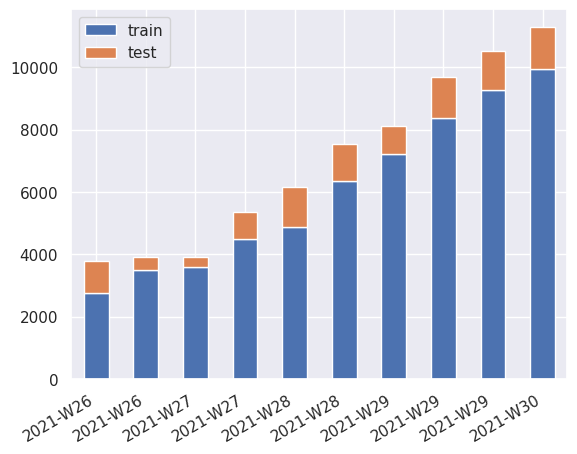

In [40]:
FIRST_FOLDS = 10
LAST_FOLDS = 0

# Bosquejo usando pandas.plot
_toplot = fold_len.set_index('t')[['train', 'test']]
_toplot['i'] = fold_len.index

_toplot = _toplot[ (_toplot['i'] < FIRST_FOLDS) | (_toplot['i'] > (len(_toplot) - LAST_FOLDS)) ]

print(_toplot)
ax = _toplot[['train', 'test']].plot.bar(stacked=True)
ax.set_xticks(np.arange(10), _toplot.index.strftime('%G-W%V'), rotation=30, ha='right')
ax.set_xlabel("")

nbutils.download_matplotlib(ax.figure, f'10_first_folds_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

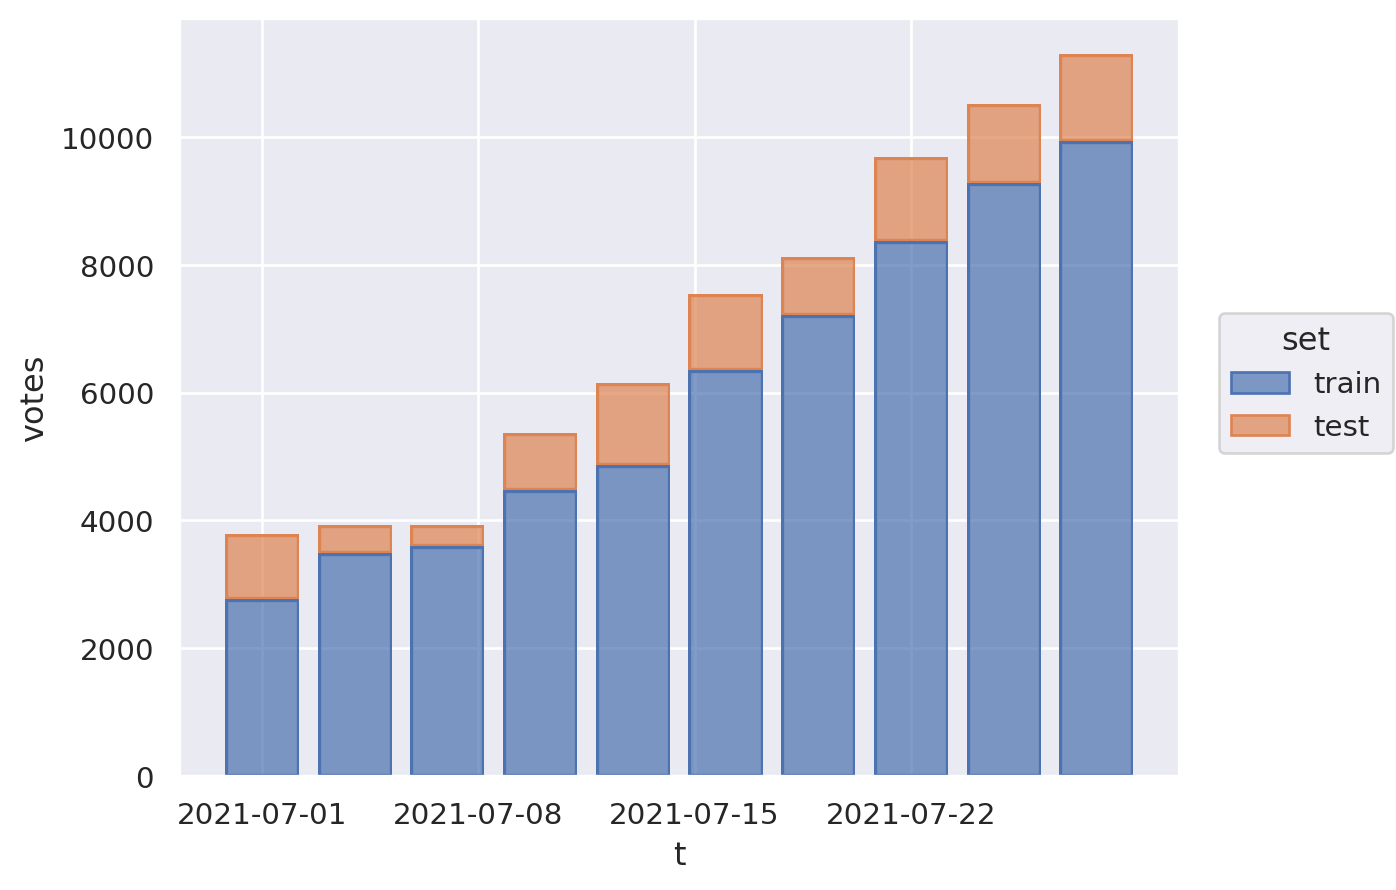

In [41]:
# Definitivo en seaborn
import seaborn.objects as so

_toplot = fold_len.assign(i=fold_len.index).melt(id_vars=['t', 'i'], value_vars=['train', 'test'], var_name='set', value_name='votes')
_toplot = _toplot[_toplot['i'] < FIRST_FOLDS]
so.Plot(_toplot, x='t', y='votes', color='set').add(so.Bar(), so.Stack())